In [394]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output as clr
import os
import numpy as np

In [5]:
device = "cpu"
if(torch.cuda.is_available()):
    deivce = "gpu"

In [17]:
# training
BATCH_SIZE = 100
if(os.path.isdir(os.path.join(os.getcwd(), 'data'))):
    trainset = datasets.MNIST('./data/', train=True, download=False,
                   transform=transforms.ToTensor())
else:
    trainset = datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
print("Done !")

Done !


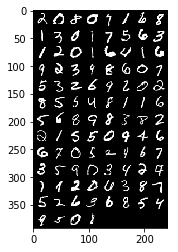

In [18]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images[0])

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
show_images(images)

In [437]:
class VAE_NP(nn.Module):
    def __init__(self, latent_variable_dim, alpha = 1.0):
        super(VAE_NP, self).__init__()
        
        ### Global Params
        # V : Stick breaking : Beta {kumaraswamy}
        
        self.aeys = nn.Parameter(torch.randn(latent_variable_dim))
        self.bees = nn.Parameter(torch.randn(latent_variable_dim))
        
        # IBP prior
        self.alpha = alpha
        self.euler_constant = np.e
        
        ### Encoder part
        self.fc1 = nn.Linear(784, 400)
        
        # A : Gaussian
        self.weight_enc_mean = nn.Parameter(torch.randn(latent_variable_dim, 400))
        self.weight_enc_std = nn.Parameter(torch.randn(latent_variable_dim, 400))
        
        # Z : Bernoulli
        self.weight_enc_phi = nn.Parameter(torch.randn(latent_variable_dim*(784 + 1), 400))
        
        # Gumbel Softmax params
        self.temperature = 10
        
        
        ### Decoder part
        self.weight_dec = nn.Parameter(torch.randn(400, latent_variable_dim, ))
        
        self.fc4 = nn.Linear(400, 784)
    
    def reparameterize_gaussian(self, log_var, mu):
        s = torch.exp(0.5*log_var)
        eps = torch.rand_like(s) - 0.5 # generate a iid standard normal same shape as s
        return eps.mul(s).add_(mu)
    
    def reparameterize_bernoulli(self, inter_z):
        '''Proper Sampling is required with masking'''
        for k in range(K):
            u[k] = unif(0,1)
            g[k] = gumbel(0,1)
            vs[k] = (1-u[k].pow(1/self.bees[k])).pow(1/self.aeys[k])
            pi[k] = pi[k-1]*vs[k]
        
        logit_pi = np.log(pi/(1-pi))
        log_alpha = logit_pi + inter_z
        
        y = nn.sigmoid((log_alpha + g)/self.temperature)
        
    
        return y
        
    def forward(self, input, k):
        x = input.view(-1, 784)
        N, D = x.shape
        x = torch.relu(self.fc1(x))
        
        if(k != 0):
            mask = torch.rand_like(self.weight_enc_mean)*0
            mask[:k,:] = 1
            
            mask2 = torch.rand_like(self.weight_enc_phi)*0
            mask2[:k,:] = 1
        else:
            mask = 1
            mask2 = 1
            
        log_s = F.linear(x, self.weight_enc_std*mask)
        m = F.linear(x, self.weight_enc_mean*mask)
        
        inter_z = F.linear(x, self.weight_enc_phi*mask2).view(785,-1) # 785 x K
        x_cat = torch.cat((input.view(N,784), torch.ones(N).view(N,-1)), 1).view(-1,785) # N x 785
        inter_z = torch.mm(x_cat, inter_z) # N x K
        
        z = self.reparameterize_bernoulli(inter_z) # N x K
        
        a = self.reparameterize_gaussian(log_s, m) # N x K
        
        az = a*z
        
        x = self.decode(az, k)
        
        return x, m, log_s
    
    def decode(self, z, k):
        
        if(k != 0):
            mask = torch.rand_like(self.weight_dec)*0
            mask[:,:k] = 1
        else:
            mask = 1
        
        
        x = F.linear(z, self.weight_dec*mask)
        x = torch.sigmoid(self.fc4(x))
        
        
        return x
    
    
    def add_k_node(self, k):
        # Add k latent features ...
        if(k == 0):
            return 
        with torch.no_grad():
            self.weight_enc_mean = nn.Parameter(torch.cat((self.weight_enc_mean, torch.randn(k, 400)), 0))
            self.weight_enc_std = nn.Parameter(torch.cat((self.weight_enc_std, torch.randn(k, 400)), 0))
            self.weight_dec = nn.Parameter(torch.cat((self.weight_dec, torch.randn(400,k)), 1))
    
    def del_k_node(self, k):
        # Retain k Latent Features ...
        if(k == 0 or k == self.weight_dec.shape[1]):
            return
        with torch.no_grad():
            c_K = self.weight_dec.shape[1]
            self.weight_enc_mean = nn.Parameter(list(torch.split(self.weight_enc_mean, c_K - k , 0))[0])
            self.weight_enc_std = nn.Parameter(list(torch.split(self.weight_enc_std, c_K - k , 0))[0])
            self.weight_dec = nn.Parameter(list(torch.split(self.weight_dec, c_K - k , 1))[0])

In [428]:
def loss(input_image, recon_image, mu, log_var):
    CE = F.binary_cross_entropy(recon_image, input_image.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    ''' Add some more KL terms from K||B ,  '''
    
    return KLD + CE

In [429]:
def retain_k_nodes(model , new_K = 0):
    
    current_K = model.weight_dec.shape[1]
    if(current_K < new_K):
        model.add_k_node(new_K - current_K)
    elif(current_K > new_K):
        model.del_k_node(current_K - new_K)
    else:
        pass
    
    optimizer = torch.optim.Adam(model.parameters())
    
    return optimizer

In [430]:
def get_kth_trunc_loss(model, images, K = 0):
    recon_image, s, mu = model(images, K)
    l = loss(images, recon_image, mu, s)
    return l

In [431]:
vae = VAE_NP(5)
optimizer = retain_k_nodes(vae , new_K = 5)

In [432]:
## train
train_loss = []
for k in range(1,10):
    optimizer = retain_k_nodes(vae , new_K = k)
    for epoch in range(1):
        for i, data in enumerate(trainloader, 0):
            images, labels = data
            images = images.to(device)
            
            optimizer.zero_grad()
            
            l = get_kth_trunc_loss(vae, images, K = 0)
            l.backward()
            
            train_loss.append(l.item() / len(images))
            optimizer.step()

            if(i%100 == 0):
                print("Epoch no :", epoch + k, "datapoint :", i)
                clr(wait = True)
        
plt.plot(train_loss)
plt.show()

KeyboardInterrupt: 

In [433]:
# test
testset = datasets.MNIST('./data/', train=False, download=False,
                   transform=transforms.ToTensor())

testloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

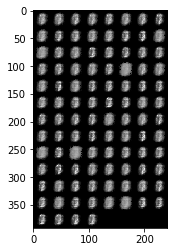

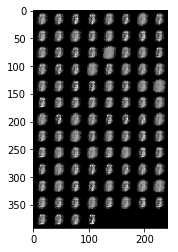

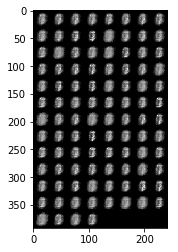

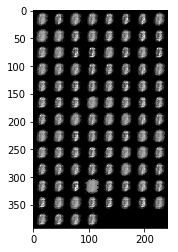

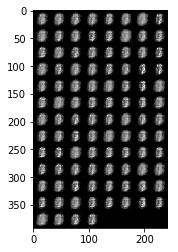

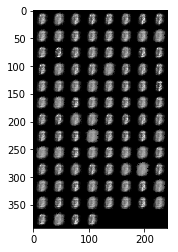

In [434]:
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        images = images.to(device)
        recon_image, s, mu = vae(images, 0)
        recon_image_ = recon_image.view(BATCH_SIZE, 1, 28, 28)
        if i % 100 == 0:
            show_images(recon_image_)

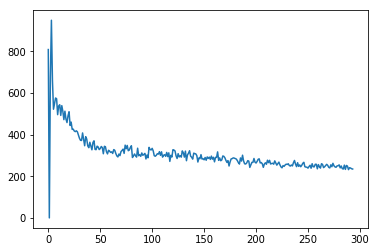

In [435]:
temp = np.array(train_loss)
plt.plot(temp*(temp < 2500))

In [403]:
np.e

2.718281828459045

In [405]:
torch.ones(10)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])